# Project: Wrangle and Analyze WeRateDogs' Twitter archive

In [1]:
# Import libraries
import pandas as pd
import requests
import tweepy
from tweepy import OAuthHandler

import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

## Data Gathering

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# Load Twitter archive
archived_tweets = pd.read_csv('twitter-archive-enhanced.csv')

2. Using the Requests library, download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    if response.status_code == 200:
        file.write(response.content)

# Read Data
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
run = False
if run:
    # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
    # These are hidden to comply with Twitter's API terms and conditions
    consumer_key = 'HIDDEN'
    consumer_secret = 'HIDDEN'
    access_token = 'HIDDEN'
    access_secret = 'HIDDEN'

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    # NOTE TO REVIEWER: this student had mobile verification issues so the following
    # Twitter API code was sent to this student from a Udacity instructor
    # Tweet IDs for which to gather additional data via Twitter's API
    tweet_ids = archived_tweets.tweet_id.values
    print(len(tweet_ids), '\n')

    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

In [5]:
tweet_list = []
with open('tweet-json.txt', encoding='utf-8') as file:
    for line in file:
        tweet_obj = json.loads(line)
        tweet_list.append({'tweet_id': tweet_obj['id'],
                           'retweet_count': tweet_obj['retweet_count'],
                           'favorite_count': tweet_obj['favorite_count']
                          })

tweet_json = pd.DataFrame(tweet_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

## Assessing Data

### Visual assessment

In [6]:
archived_tweets

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


#### Quality
* Missing values in the columns `in_reply_to_status_id` and `in_reply_to_user_id`. These two columns seem to contain all NaNs. The `retweeted_...` columns also seem to be mostly NaNs.
* HTML syntax bordering the urls in the `source` column

#### Tidiness
* The last four columns, `doggo, floofer, pupper, puppo`, can be merged into one column, tentatively named, `dog_type`; This column can be assigned a `category` type.
* Drop columns containing extraneous information

In [7]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


#### Quality
* Number of rows less than that for the `archived_tweets` table
* Some predictions are not dog types: row `2074` is an example

#### Tidiness
* This table may need to be merged with the `archived_tweets` table.
* More descriptive column names.

In [8]:
tweet_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


#### Tidiness
* May need a merge with the `archived_tweets` table

### Programmatic assessment

In [9]:
archived_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### Quality
* The `in_reply_to_user_id` and `in_reply_to_status_id` columns both contain 78 non-null entries. These entries should be removed since they indicate replies to other tweets and we need original tweets.
* The `retweeted_...` columns also contain some non-null entries indicating retweets and should be removed.
* Missing values in the `expanded_urls` column.
* The `tweet_id` column could be stored as strings not int since they are unique identifiers.
* The `timestamp` column should converted from object to a datetime datatype

In [10]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* `tweet_id` is of string type.

In [11]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


* `tweet_id` is of string type.

In [12]:
archived_tweets.sample(5, random_state=2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
241,846505985330044928,NaN,NaN,2017-03-27 23:35:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",THIS WAS NOT HIS FAULT HE HAD NO IDEA. 11/10 S...,NaN,NaN,NaN,https://twitter.com/shomaristone/status/846484...,11,10,None,None,None,None,None
323,834089966724603904,NaN,NaN,2017-02-21 17:18:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",DOGGO ON THE LOOSE I REPEAT DOGGO ON THE LOOSE...,NaN,NaN,NaN,https://twitter.com/stevekopack/status/8340866...,10,10,None,doggo,None,None,None
2033,671744970634719232,NaN,NaN,2015-12-01 17:37:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Very fit horned dog here. Looks powerful. Not ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671744970...,6,10,None,None,None,None,None
1985,672898206762672129,NaN,NaN,2015-12-04 22:00:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cheryl AKA Queen Pupper of the Skies. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672898206...,11,10,Cheryl,None,None,pupper,None
79,877556246731214848,NaN,NaN,2017-06-21 15:58:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's both pupset and fired pup...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/877556246...,12,10,Penny,None,None,None,None


* Some rows in the `text` column contained capitalized words.
* **None** instead of **NaN** in the last 5 columns of the `archived_tweets` table

In [13]:
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1109,723912936180330496,https://pbs.twimg.com/media/Cgva-QqUUAA7Hv9.jpg,1,Samoyed,0.991772,True,Pomeranian,0.003626,True,chow,0.002232,True
1991,873580283840344065,https://pbs.twimg.com/media/DB-UotKXkAEHXVi.jpg,1,Newfoundland,0.678537,True,Tibetan_mastiff,0.244022,True,chow,0.048530,True
2064,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True
1133,728409960103686147,https://pbs.twimg.com/media/ChvU_DwWMAArx5L.jpg,1,Siamese_cat,0.478278,False,Saint_Bernard,0.094246,True,king_penguin,0.082157,False
922,702217446468493312,https://pbs.twimg.com/media/Cb7HCMkWEAAV9zY.jpg,1,golden_retriever,0.242419,True,chow,0.226800,True,cocker_spaniel,0.194086,True


In [14]:
tweet_json.sample(5)

,tweet_id,retweet_count,favorite_count
618,796149749086875649,16628,36177
110,871032628920680449,3999,23255
1926,674045139690631169,710,1520
1542,689517482558820352,1609,3735
393,825829644528148480,2848,14025


In [15]:
archived_tweets.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,2356,NaN,NaN,NaN,7.42772e+17,6.8567e+16,6.66021e+17,6.78399e+17,7.19628e+17,7.99337e+17,8.92421e+17
in_reply_to_status_id,78,NaN,NaN,NaN,7.45508e+17,7.58249e+16,6.65815e+17,6.75742e+17,7.03871e+17,8.2578e+17,8.86266e+17
in_reply_to_user_id,78,NaN,NaN,NaN,2.01417e+16,1.2528e+17,1.18563e+07,3.08637e+08,4.19698e+09,4.19698e+09,8.40548e+17
timestamp,2356,2356,2017-07-09 00:00:04 +0000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,2356,4,"<a href=""http://twitter.com/download/iphone"" r...",2221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,2356,2356,This is Charlie. He works for @TODAYshow. Supe...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweeted_status_id,181,NaN,NaN,NaN,7.7204e+17,6.23693e+16,6.66104e+17,7.18631e+17,7.80466e+17,8.20315e+17,8.87474e+17
retweeted_status_user_id,181,NaN,NaN,NaN,1.2417e+16,9.59925e+16,783214,4.19698e+09,4.19698e+09,4.19698e+09,7.87462e+17
retweeted_status_timestamp,181,181,2016-12-12 16:16:49 +0000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expanded_urls,2297,2218,https://twitter.com/dog_rates/status/759447681...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Only 4 unique urls in the `source` column. This column is perhaps not needed.
* Max `rating_numerator` value of 1776 and max `rating_denominator` value of 170.
* A lot of rows with missing dog names represented as **None**

In [16]:
image_predictions.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,2075,NaN,NaN,NaN,7.38451e+17,6.7852e+16,6.66021e+17,6.76484e+17,7.11999e+17,7.93203e+17,8.92421e+17
jpg_url,2075,2009,https://pbs.twimg.com/ext_tw_video_thumb/81742...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
img_num,2075,NaN,NaN,NaN,1.20386,0.561875,1,1,1,1,4
p1,2075,378,golden_retriever,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p1_conf,2075,NaN,NaN,NaN,0.594548,0.271174,0.0443334,0.364412,0.58823,0.843855,1
p1_dog,2075,2,True,1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p2,2075,405,Labrador_retriever,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p2_conf,2075,NaN,NaN,NaN,0.134589,0.100666,1.0113e-08,0.0538862,0.118181,0.195566,0.488014
p2_dog,2075,2,True,1553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p3,2075,408,Labrador_retriever,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
tweet_json.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
tweet_id,2354.0,7.426978e+17,6.852812e+16,6.660209e+17,6.783975e+17,7.194596e+17,7.993058e+17,8.924206e+17
retweet_count,2354.0,3.164797e+03,5.284770e+03,0.000000e+00,6.245000e+02,1.473500e+03,3.652000e+03,7.951500e+04
favorite_count,2354.0,8.080969e+03,1.181477e+04,0.000000e+00,1.415000e+03,3.603500e+03,1.012225e+04,1.328100e+05


In [18]:
archived_tweets.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

* Numerator values above 15 and below 10 are invalid

In [19]:
archived_tweets.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

* Denominator values above  or below 10 are invalid

In [20]:
archived_tweets.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Cooper           11
Oliver           11
Lola             10
Penny            10
Tucker           10
Winston           9
Bo                9
the               8
Sadie             8
Daisy             7
an                7
Bailey            7
Buddy             7
Toby              7
Koda              6
Milo              6
Rusty             6
Scout             6
Oscar             6
Jax               6
Stanley           6
Jack              6
Bella             6
Dave              6
Leo               6
Sammy             5
               ... 
Brian             1
Bobble            1
Stella            1
Pilot             1
Snicku            1
Boots             1
Winifred          1
Pete              1
Oreo              1
Clifford          1
Grizzwald         1
Shelby            1
Cleopatricia      1
Remy              1
Tuco              1
Schnozz           1
Gunner            1
Zoe               1
Ralph             1


* Inaccurate dog names. Examples are 'a', 'an', 'by' and 'O'.

In [21]:
archived_tweets[archived_tweets.name == 'an']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
759,778396591732486144,NaN,NaN,2016-09-21 00:53:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is an East African Chalupa...,7.030419e+17,4.196984e+09,2016-02-26 02:20:37 +0000,https://twitter.com/dog_rates/status/703041949...,10,10,an,None,None,None,None
1025,746369468511756288,NaN,NaN,2016-06-24 15:48:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Iraqi Speed Kangaroo. It is not a d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746369468...,9,10,an,None,None,None,None
1362,703041949650034688,NaN,NaN,2016-02-26 02:20:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an East African Chalupa Seal. We only ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703041949...,10,10,an,None,None,None,None
2204,668636665813057536,NaN,NaN,2015-11-23 03:46:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Irish Rigatoni terrier named Berta....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668636665...,10,10,an,None,None,None,None
2333,666337882303524864,NaN,NaN,2015-11-16 19:31:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an extremely rare horned Parthenon. No...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666337882...,9,10,an,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None


In [22]:
image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
Cardigan                      19
web_site                      19
Maltese_dog                   18
Eskimo_dog                    18
Shetland_sheepdog             18
teddy                         18
beagle                        18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
kuvasz                        16
Italian_greyhound             16
          

In [23]:
image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [24]:
tweet_json.favorite_count.value_counts()

0        179
610        3
345        3
2918       3
1691       3
2176       3
2768       3
1339       3
2706       3
522        2
3134       2
1618       2
250        2
2250       2
2660       2
2262       2
2305       2
1111       2
784        2
4878       2
346        2
14685      2
780        2
6923       2
6515       2
2433       2
3603       2
13518      2
3593       2
1536       2
        ... 
4681       1
523        1
559        1
802        1
527        1
27154      1
6676       1
535        1
537        1
6682       1
8731       1
23074      1
21029      1
667        1
6696       1
2608       1
35400      1
21041      1
4659       1
10804      1
4099       1
68152      1
10812      1
573        1
6718       1
33345      1
814        1
23108      1
2630       1
8143       1
Name: favorite_count, Length: 2007, dtype: int64

In [25]:
tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Quality issues
#### `archived_tweets`

1. Retweets and replies to original tweets are included. Only original tweets are needed.

2. Extraneous columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`.

3. Erroneous datatypes in the `tweet_id` (also needs to be changed in the other two tables) and `timestamp` columns.

4. Invalid values in the `rating_numerator` and `rating_denominator` columns. The numerator is usually between 10 and 15 while the denominator rating is always 10.

5. Inaccurate dog names. Examples are 'a', 'an', 'by', 'O'... This is a result of incorrect extraction of dog names from the `text` column.

#### `image_predictions`
6. Some rows contain predictions that are not dog types.

7. Non-descriptive column headers: `p1`, `p1_conf`, `p1_dog`.

8. Extraneous columns: `jpg_url`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog`.

9. Tweet IDs should be stored as strings/objects.

#### `tweet_json`
10. Tweet IDs should be stored as strings/objects.

### Tidiness issues
1. The last four column headers in the `archived_tweets` table qualify as variable values not variable names and so needs consolidation into a column.

2. The `retweet_count` and `favorite_count` columns of the `tweet_json` table should be included in the `archived_tweets` table.

3. Some columns in the `image_predictions` table should be part of the `archived_tweets` table

## Cleaning Data

In [26]:
# Make copies of original data
archived_tweets_clean = archived_tweets.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

### Issue #1:
#### `archived_tweets`: Retweets and replies to original tweets are included. Only original tweets are needed.

#### Define:
Remove rows containing retweets or replies to tweets using boolean indexing.

#### Code

In [27]:
# Keep only rows where values in 'in_reply_to_status_id' and 'retweeted_status_id' are not null
bool_mask = (archived_tweets_clean.in_reply_to_status_id.isna()) & (archived_tweets_clean.retweeted_status_id.isna())
archived_tweets_clean = archived_tweets_clean[bool_mask]

#### Test

In [28]:
archived_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

### Issue #2:
#### `archived_tweets`: Extraneous columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`.

#### Define
Remove columns containing info about retweets and replies using pandas' `drop` method.

#### Code

In [29]:
# Drop these columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, 
#                     retweeted_status_user_id, and retweeted_status_timestamp
archived_tweets_clean.drop(inplace=True, columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                                                  'retweeted_status_user_id', 'retweeted_status_timestamp'])

#### Test

In [30]:
archived_tweets_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### Issue #3:
#### `archived_tweets`: The last four column headers qualify as variable values not names and so needs consolidation into a column.

#### Define
Consolidate these 4 columns into a column, `dog_type`, with values corresponding to 'doggo', 'floofer', 'pupper', and 'puppo'. Drop the original columns

#### Code

In [31]:
# Function to extract dog_type from columns
def return_dogtype(row):
    d_types = ['doggo', 'floofer', 'pupper', 'puppo']
    res = []
    for d_type in d_types:
        if d_type in row.values:
            res.append(d_type)
    return '/'.join(res) if res else 'Unknown'

# Create a new dog_type column
archived_tweets_clean['dog_type'] = archived_tweets_clean.iloc[:, -4:].apply(return_dogtype, axis=1)

# Drop original 4 columns
archived_tweets_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [32]:
display(archived_tweets_clean.head(3))
archived_tweets_clean.columns

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,Unknown
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown


Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_type'],
      dtype='object')

### Issue #4:
`archived_tweets`: Erroneous datatypes in the `tweet_id` (also needs to be changed in the other two tables) and `timestamp` columns.

Tweet IDs in the remaining tables should be stored as strings.

#### Define
Make these columns have `object` and `datetime` datatypes.

#### Code

In [33]:
# For archived_tweets
archived_tweets_clean['tweet_id'] = archived_tweets_clean.tweet_id.astype('str')
archived_tweets_clean['timestamp'] = pd.to_datetime(archived_tweets_clean.timestamp)

# For tweet_json
tweet_json_clean['tweet_id'] = tweet_json_clean.tweet_id.astype('str')

# for image_predictions
image_predictions_clean['tweet_id'] = image_predictions_clean.tweet_id.astype('str')

#### Test

In [34]:
display(archived_tweets_clean.dtypes)
display(tweet_json_clean.dtypes)
image_predictions_clean.dtypes

tweet_id                      object
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
dog_type                      object
dtype: object

tweet_id          object
retweet_count      int64
favorite_count     int64
dtype: object

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

### Issue #5:
#### `archived_tweets`: Invalid values in the `rating_numerator` and `rating_denominator` columns.

#### Define
Select only rows that have `rating_numerator` values between 10 and 15 as well as `rating_denominator` values of 10

#### Code

In [35]:
# Create boolean mask
bool_ = (archived_tweets_clean.rating_numerator.between(10, 15)) & (archived_tweets_clean.rating_denominator == 10)
# Select rows
archived_tweets_clean = archived_tweets_clean[bool_]

#### Test

In [36]:
# Frequency tables for both columns
display(archived_tweets_clean.rating_numerator.value_counts())
archived_tweets_clean.rating_denominator.value_counts()

12    486
10    436
11    413
13    287
14     38
Name: rating_numerator, dtype: int64

10    1660
Name: rating_denominator, dtype: int64

### Issue #6:
#### `archived_tweets`: Inaccurate dog names. Examples are 'a', 'an', 'by' and 'O'...

#### Define
Replace inaccurate dog names with 'Unknown'

#### Code

In [37]:
# These names were curated after going through a list of unique names in the `name` column
false_names = ['a', 'an', 'by', 'O', 'one', 'very', 'the', 'just', 'quite', 'actually',
              'not', 'getting', 'his', 'light', 'life', 'all', 'incredibly', 'my', 'old',
              'mad', 'space', 'such', 'infuriating']

# Replace invalid names with 'Unknown' for now
archived_tweets_clean['name'] = archived_tweets_clean.name.replace(false_names, 'Unknown')

#### Test

In [38]:
assert archived_tweets_clean.name.isin(false_names).sum() == 0

### Issue #7:
#### `image_predictions`: Some rows contain predictions that are not dog types

#### Define
Select only rows with dog names i.e. where the `p1_dog` column values are `True`.

#### Code

In [39]:
image_predictions_clean = image_predictions_clean[image_predictions_clean.p1_dog == True]

#### Test

In [40]:
assert (image_predictions_clean.p1_dog == False).sum() == 0

### Issue #8:
#### `image_predictions`: Non-descriptive column headers: `p1`, `p1_conf`, `p1_dog`.

#### Define
Give the above headers more descriptive names.

#### Code

In [41]:
new_col_names ={'p1': 'prediction_1',
                'p1_conf': 'prediction_confidence',
                'p1_dog': 'is_dog'}
image_predictions_clean = image_predictions_clean.rename(columns=new_col_names)

In [42]:
image_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_1',
       'prediction_confidence', 'is_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

### Issue #9:
#### `image_predictions`: Extraneous columns: `jpg_url`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog`

#### Define
Remove the above columns from the table using the `drop` method.

#### Code

The `retweet_count` and `favorite_count` columns of the `tweet_json` table should be included in the `archived_tweets` table

In [43]:
cols_2_drop = ['jpg_url', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

image_predictions_clean = image_predictions_clean.drop(columns=cols_2_drop)

#### Test

In [44]:
image_predictions_clean.columns

Index(['tweet_id', 'img_num', 'prediction_1', 'prediction_confidence',
       'is_dog'],
      dtype='object')

### Issue #10:
#### The `retweet_count` and `favorite_count` columns of the `tweet_json` table should be included in the `archived_tweets` table

#### Define
Add these two columns to the `archived_tweets` table using Pandas' `merge` function

#### Code

In [45]:
archived_tweets_clean = archived_tweets_clean.merge(tweet_json_clean, how='left', on='tweet_id')

#### Test

In [46]:
archived_tweets_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,Unknown,8853,39467
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,6514,33819
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown,4328,25461
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,Unknown,8964,42908
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Unknown,9774,41048


### Issue #11:
#### Some columns in the `image_predictions` table should be part of the `archived_tweets` table

#### Define
Merge the `image_predictions` table to the `archived_tweets` table using Pandas' `merge` function

#### Code

In [47]:
archived_tweets_clean = archived_tweets_clean.merge(image_predictions_clean, how='inner', on='tweet_id')

#### Test

In [48]:
archived_tweets_clean.info()
archived_tweets_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228 entries, 0 to 1227
Data columns (total 15 columns):
tweet_id                 1228 non-null object
timestamp                1228 non-null datetime64[ns]
source                   1228 non-null object
text                     1228 non-null object
expanded_urls            1228 non-null object
rating_numerator         1228 non-null int64
rating_denominator       1228 non-null int64
name                     1228 non-null object
dog_type                 1228 non-null object
retweet_count            1228 non-null int64
favorite_count           1228 non-null int64
img_num                  1228 non-null int64
prediction_1             1228 non-null object
prediction_confidence    1228 non-null float64
is_dog                   1228 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(7)
memory usage: 145.1+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,retweet_count,favorite_count,img_num,prediction_1,prediction_confidence,is_dog
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,6514,33819,1,Chihuahua,0.323581,True
1,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown,4328,25461,1,Chihuahua,0.716012,True
2,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Unknown,9774,41048,2,basset,0.555712,True
3,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,Unknown,3261,20562,1,Chesapeake_Bay_retriever,0.425595,True
4,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,Unknown,2158,12041,1,Appenzeller,0.341703,True


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [49]:
archived_tweets_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
Let's do a brief analysis of the cleaned data

In [50]:
# What are the top 3 predicted dog breeds
archived_tweets_clean.prediction_1.str.replace('_', ' ').str.title().value_counts()[:3]

Golden Retriever      127
Labrador Retriever     83
Pembroke               83
Name: prediction_1, dtype: int64

In [51]:
# What are the maximum retweet and favourite counts
max_retweet_cnt = archived_tweets_clean.retweet_count.max()
max_favorite_cnt = archived_tweets_clean.favorite_count.max()

print('Maximum retweet count:', f'{max_retweet_cnt:,}', 
      '\nMaximum favourite count:', f'{max_favorite_cnt:,}')

Maximum retweet count: 79,515 
Maximum favourite count: 132,810


In [52]:
# Most common 'known' WeRateDogs' dog type
archived_tweets_clean.dog_type.value_counts()

Unknown          1024
pupper            125
doggo              46
puppo              18
floofer             7
doggo/pupper        6
doggo/puppo         1
doggo/floofer       1
Name: dog_type, dtype: int64

### Insights:
1. The top 3 predicted dog breeds are: Golden Retriever, Labrador Retriever and Pembroke 

2. The most retweet and favourite counts respectively are 79,515 and 132,810

3. The most common WeRateDogs' dog type is the **pupper**

### Visualization

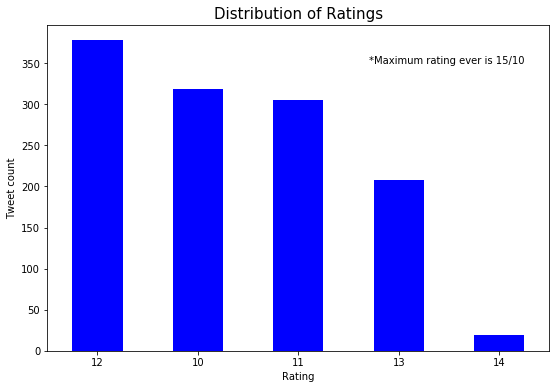

In [53]:
# What is the most common rating numerator?
archived_tweets_clean.rating_numerator.value_counts().plot.bar(rot=0, color='Blue', figsize=[9,6])
plt.xlabel('Rating')
plt.ylabel('Tweet count')
plt.title('Distribution of Ratings', fontsize=15)
plt.text(2.7, 350, '*Maximum rating ever is 15/10');
plt.savefig('ratings_distribution.png')

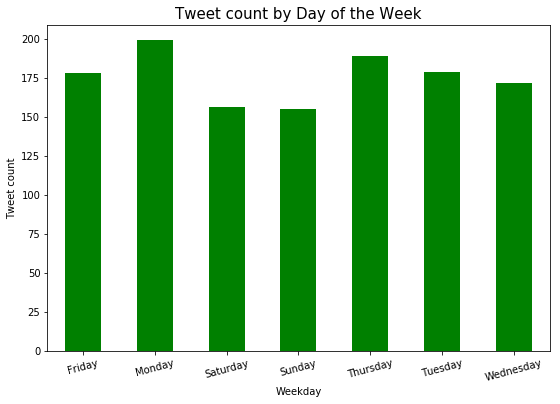

In [54]:
tweets_by_day = archived_tweets_clean.groupby(archived_tweets_clean.timestamp.dt.weekday_name)['tweet_id'].count()

tweets_by_day.plot.bar(rot=15, color='Green', figsize=[9,6])
plt.xlabel('Weekday')
plt.ylabel('Tweet count')
plt.title('Tweet count by Day of the Week', fontsize=15);
# plt.savefig('tweet_cnt_by_day.png')